In [4]:
source('helpers.R')
kaggle.house.loadLibraries()

df.combined = kaggle.house.PrepareCombinedDataSet()
df.lot_frontage = df.combined %>% filter(!is.na(LotFrontage))

In [53]:
colNames = names(which(sapply(df.lot_frontage, is.character)))
colNames = c(colNames, "LotFrontage.Log", "LotArea.Log")

df.rsquared = df.lot_frontage %>% 
    select(colNames) %>% 
    gather(attr, attr_val, -LotFrontage.Log, -LotArea.Log) %>% 
    group_by(attr, attr_val) %>%
    do(glance(lm(LotFrontage.Log ~ LotArea.Log, data=.))) %>%
    select(attr, attr_val, r.squared)

df.freq = df.lot_frontage %>% 
    select(colNames) %>% 
    gather(attr, attr_val, -LotFrontage.Log, -LotArea.Log) %>% 
    group_by(attr, attr_val) %>%
    summarise(n=n())%>%
    mutate(freq = n / sum(n))

df.joint = inner_join(df.rsquared, df.freq, by = c("attr", "attr_val"))
df.joint %>% 
    mutate(freq.rsquared = r.squared * freq) %>% 
    group_by(attr) %>%
    summarise(rsquared.expect = sum(freq.rsquared)) %>%
    arrange(desc(rsquared.expect))

attr,rsquared.expect
LotConfig,0.6512306
LotConfig2,0.6454040
LotShape,0.6092392
LotShape2,0.6000610
LandSlope,0.5976722
LandContour,0.5967093
Heating,0.5939265
RoofMatl,0.5910707
BsmtFinType2,0.5908101
Street,0.5878182


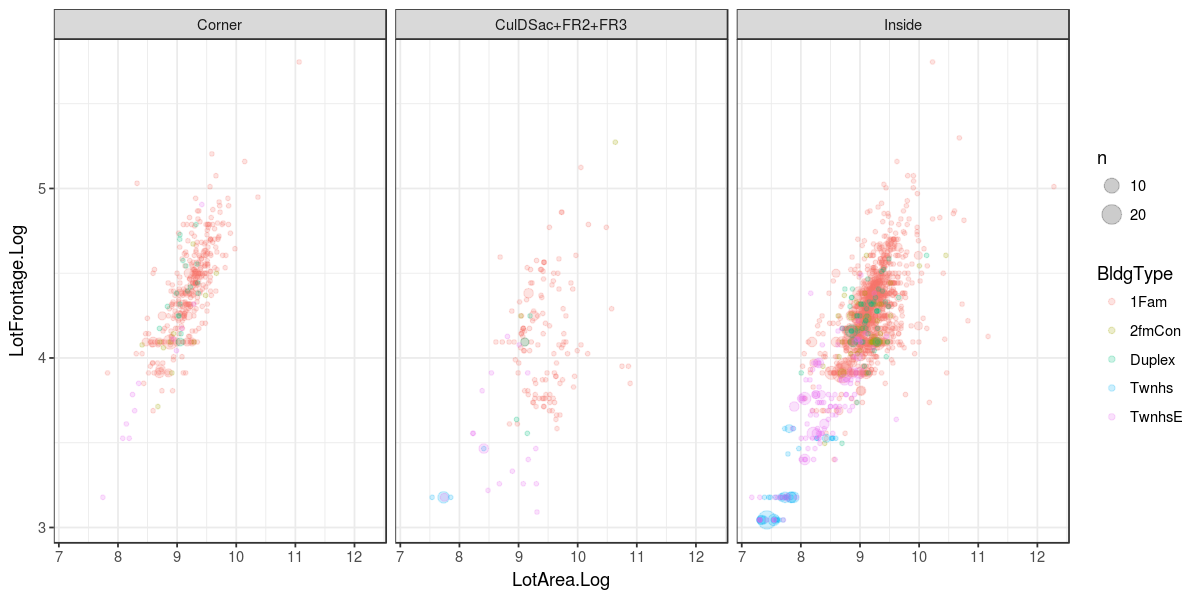

In [78]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(df.lot_frontage, aes(x=LotArea.Log, y=LotFrontage.Log)) +
    geom_count(aes(colour = BldgType), alpha=0.2) +
    facet_wrap(~LotConfig2) +
    theme_bw()

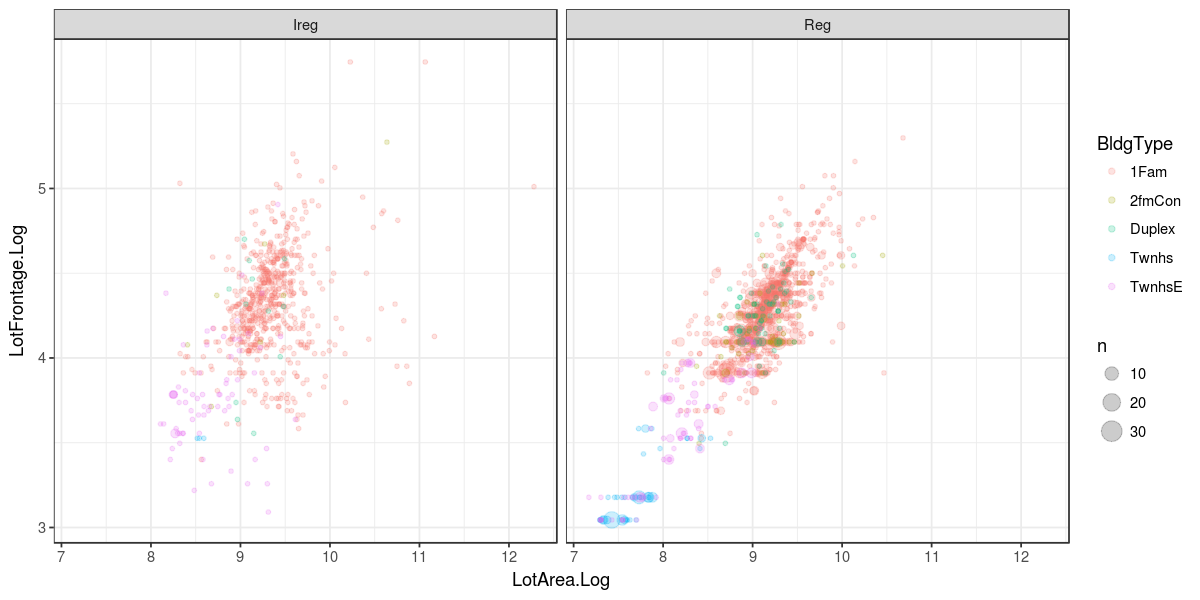

In [79]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(df.lot_frontage, aes(x=LotArea.Log, y=LotFrontage.Log)) +
    geom_count(aes(colour = BldgType), alpha=0.2) +
    facet_grid(~LotShape2) +
    theme_bw()

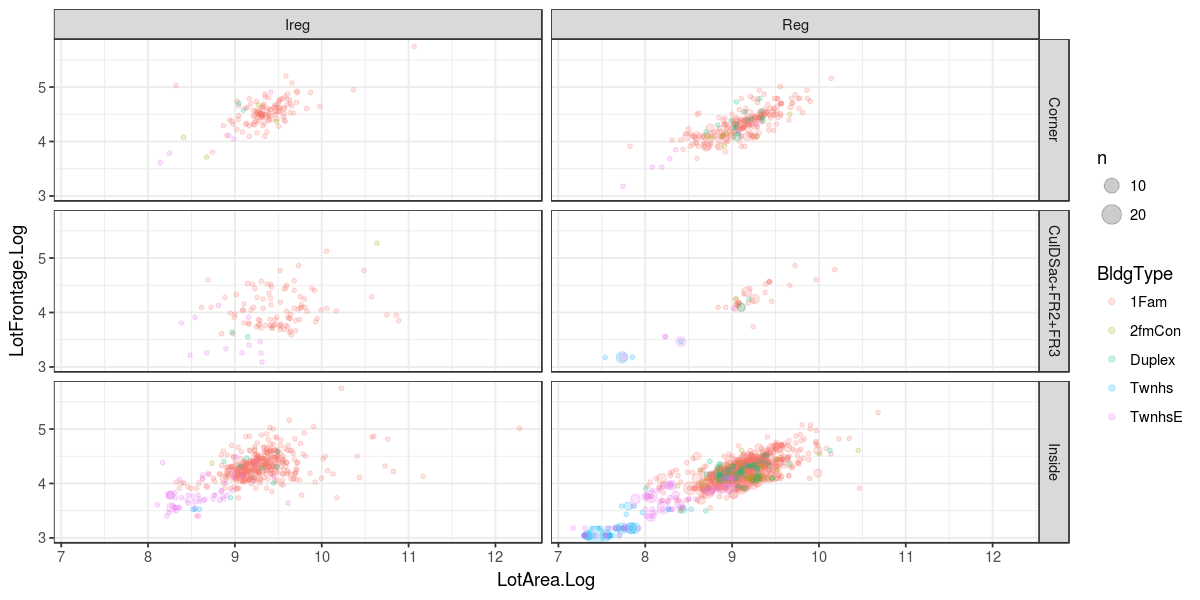

In [80]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(df.lot_frontage, aes(x=LotArea.Log, y=LotFrontage.Log)) +
    geom_count(aes(colour = BldgType), alpha=0.2) +
    facet_grid(LotConfig2~LotShape2) +
    theme_bw()

In [90]:
df.rsquared = df.lot_frontage %>% 
    group_by(LotConfig2, LotShape2) %>% 
    do(glance(lm(LotFrontage.Log ~ LotArea.Log, data=.))) %>%
    select(LotConfig2, LotShape2, r.squared)

df.freq = df.lot_frontage %>% 
    group_by(LotConfig2, LotShape2) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / sum(n)) 

df.rsquared
df.freq

df.joint = inner_join(df.rsquared, df.freq, by = c("LotConfig2", "LotShape2"))
df.joint %>% 
    mutate(freq.rsquared = r.squared * freq) #%>% 
    #summarise(rsquared.expect = sum(freq.rsquared))

LotConfig2,LotShape2,r.squared
Corner,Ireg,0.45332168
Corner,Reg,0.62402057
CulDSac+FR2+FR3,Ireg,0.09454551
CulDSac+FR2+FR3,Reg,0.92206654
Inside,Ireg,0.33510098
Inside,Reg,0.77629462


LotConfig2,LotShape2,n,freq
Corner,Ireg,130,0.3194103
Corner,Reg,277,0.6805897
CulDSac+FR2+FR3,Ireg,110,0.6707317
CulDSac+FR2+FR3,Reg,54,0.3292683
Inside,Ireg,466,0.2502685
Inside,Reg,1396,0.7497315


LotConfig2,LotShape2,r.squared,n,freq,freq.rsquared
Corner,Ireg,0.45332168,130,0.3194103,0.14479562
Corner,Reg,0.62402057,277,0.6805897,0.42470196
CulDSac+FR2+FR3,Ireg,0.09454551,110,0.6707317,0.06341467
CulDSac+FR2+FR3,Reg,0.92206654,54,0.3292683,0.30360728
Inside,Ireg,0.33510098,466,0.2502685,0.08386523
Inside,Reg,0.77629462,1396,0.7497315,0.58201251
